# PySnpTools Paper Examples

See [PySnpTools's README.md](https://github.com/fastlmm/PySnpTools/blob/master/README.md) for slides, video, installation instructions, documentation, and code.

> Version 0.4.22, September 13, 2020

### Contacts

* Email the developers at fastlmm-dev@python.org.
* [Join](mailto:fastlmm-user-join@python.org?subject=Subscribe) the user discussion and announcement list (or use [web sign up](https://mail.python.org/mailman3/lists/fastlmm-user.python.org)).
* [Open an issue](https://github.com/fastlmm/PySnpTools/issues) on GitHub.


## Step up notebook

In [1]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output)
import logging
logging.basicConfig(level=logging.WARNING)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## Reading Genomic Files

#### Example
Create a "Bed" snpreader. Tell it what file to read and how to read it. The snpreader, as yet, reads no files.

In [2]:
# Download BED files and return local file name
from pysnptools.util import example_file
all_bed_file = example_file("doc/ipynb/all.*",endswith="*.bed")
all_bed_file

'M:\\Temp\\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/all.bed'

In [3]:
from pysnptools.snpreader import Bed
snpreader = Bed(all_bed_file, count_A1=True)
print(snpreader)

Bed('M:\Temp\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/all.bed',count_A1=True)


Ask the snpreader for the number of individuals and the number of SNPs. Ask it for the iid of the first individual. Ask it for the sid of the last SNP. The snpreader reads only the small files needed to answer these questions.

In [4]:
print(snpreader.iid_count,snpreader.sid_count)
print(snpreader.iid[0])
print(snpreader.sid[-1])

500 5000
['cid0P0' 'cid0P0']
snp124_m0_.23m1_.08


Read all the genomic data into memory, creating a "SnpData" snpreader. Ask the snpdata for the number of individuals and the number of SNPs.

In [5]:
snpdata = snpreader.read()
print(snpdata)
print(snpdata.iid_count, snpdata.sid_count)

SnpData(Bed('M:\Temp\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/all.bed',count_A1=True))
500 5000


A SnpData contains a "val" property that other SnpReaders to not. The "val" property is a in-memory NumPy array of the genomic data.

Show the genomic data for the first 7 individuals and first 7 SNPs. Find the mean of all the genomic data.

In [6]:
import numpy as np
print(snpdata.val[:7,:7])
print(np.mean(snpdata.val))

[[0. 0. 1. 2. 0. 1. 2.]
 [0. 0. 1. 1. 0. 0. 2.]
 [0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 1. 0. 0. 0. 2.]
 [0. 0. 2. 1. 0. 1. 2.]]
0.521412


Here is everything in one line.

In [7]:
print(np.mean(Bed(all_bed_file,count_A1=True).read().val))

0.521412


## SnpData

SnpData, the special in-memory SnpReader, is created by any SnpReader's read() method. We can also create a SnpData from scratch.

Here we create snpdata1 for three individuals and two SNPs. We use NaN to mark a missing value and then ask for the mean value (ignoring the missing value).

In [8]:
from pysnptools.snpreader import SnpData
snpdata1 = SnpData(iid=[['f1','c1'],['f1','c2'],['f2','c1']],
                   sid=['snp1','snp2'],
                   val=[[0,1],[2,.5],[.5,np.nan]])
print(np.nanmean(snpdata1.val))

0.8


*<font color='red'>see PowerPoint summary</font>*

## Reading subsets of data, reading with re-ordering iids & sids (rows & cols), stacking

https://docs.scipy.org/doc/numpy/user/basics.indexing.html

Suppose, we only want the genomic data for the first 7 individuals and first 7 SNPs. PySnpTools makes it easy to read just the desired data from disk. Just use NumPy-like indexing *before* the read method.

In [9]:
snpreader = Bed(all_bed_file,count_A1=True)
snpdata77 = snpreader[:7,:7].read()
print(snpdata77.val)

[[0. 0. 1. 2. 0. 1. 2.]
 [0. 0. 1. 1. 0. 0. 2.]
 [0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 2.]
 [0. 0. 1. 0. 0. 0. 2.]
 [0. 0. 2. 1. 0. 1. 2.]]


All NumPy-like fancy indexing is supported: slicing, Boolean, lists of integers, negative integers. PySnpTools allows indexing on both rows and columns at once. Adding indexing to a SnpReader, creates a new SnpReader.

Here is an extreme example. It says, create a reader
* from "all.bed" in Bed format
* with the individuals in reverse order and for every 2nd SNP
* for the first 5 such individuals and first 5 such SNPs
* for the first and last individuals and the first, 2nd, and 5th SNP.
* Then, read.
      
As before, only the final, desired data is read from the disk.

In [10]:
print(Bed(all_bed_file,count_A1=True)[::-1,::2][:5,:5][[0,-1],[True,True,False,False,True]].read().val)

[[0. 0. 1.]
 [0. 1. 1.]]


The ability to create new readers via indexing, simplifies common tasks such as reading ranges of SNP, filtering out some individuals or SNPs, and reordering individuals.

We've seen how to manipulate SnpReaders with NumPy-like indexing. What if want instead manipulate SnpReaders by iid or sid, in the spirit of Pandas? In that case, use the sid_to_index() or sid_to_index() method.

For example, here we create a SnpReader that reads only the three named SNPs.

In [11]:
desired_sid_list = ['snp1750_m0_.02m1_.04',
        'snp0_m0_.37m1_.24','snp122_m0_.26m1_.34']
snpreader = Bed(all_bed_file,count_A1=True)
desired_snpreader = \
       snpreader[:,snpreader.sid_to_index(desired_sid_list)]
print(desired_snpreader.iid_count,desired_snpreader.sid_count)

500 3


In [12]:
snp0data = snpreader.read()
print(snp0data.val)

[[0. 0. 1. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 2. 0.]
 [0. 0. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 2. 0.]]


### Print the data for iid #9 (in one line)

In [13]:
print(Bed(all_bed_file,count_A1=True)[5,:].read().val)

[[0. 0. 1. ... 0. 0. 1.]]


### Read the data for the first 5 iids AND the first 5 sids:

In [14]:
snp55data = Bed(all_bed_file,count_A1=False)[:5,:5].read()
print(snp55data.val)

[[2. 2. 1. 0. 2.]
 [2. 2. 1. 1. 2.]
 [2. 2. 1. 0. 1.]
 [2. 2. 2. 0. 2.]
 [2. 2. 2. 2. 2.]]


### Stacking indexing is OK and efficient
Recall NumPy slice notation: start:stop:step, so ::2 is every other

In [15]:
snpreaderA = Bed(all_bed_file,count_A1=False)
snpreaderB = snpreaderA[:,:250]
snpreaderC = snpreaderB[:10,:]
snpreaderD = snpreaderC[::2,::2]
print(snpreaderD)
print(snpreaderD.iid_count, snpreaderD.sid_count)
print(np.nanmean(snpreaderD.read().val))

Bed('M:\Temp\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/all.bed',count_A1=False)[:,:250][:10,:][::2,::2]
5 125
1.4496


### Fancy indexing - list of indexes, slices, list of booleans, negatives(?)
on iid or sid or both

In [16]:
# List of indexes (can use to reorder)
snpdata43210 = Bed(all_bed_file,count_A1=False)[[4,3,2,1,0],:].read()
print(snpdata43210.iid)

[['cid4P0' 'cid4P0']
 ['cid3P0' 'cid3P0']
 ['cid2P0' 'cid2P0']
 ['cid1P0' 'cid1P0']
 ['cid0P0' 'cid0P0']]


In [17]:
# List of booleans to select
snp43210B = snpdata43210[[False,True],:]
print(snp43210B)
print(snp43210B.iid)

SnpData(Bed('M:\Temp\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/all.bed',count_A1=False)[[4,3,2,1,0],:])[1,:]
[['cid3P0' 'cid3P0']]


### Question: Does snp43210B have a val property?

In [18]:
print(hasattr(snp43210B,'val'))

False


Answer: No. It's a subset of a SnpData, so it will read from a SnpData, but it is not a SnpData.
Use .read() to get the values.

In [19]:
snpdata4321B = snp43210B.read(view_ok=True) #view_ok means ok to share memory
print(snpdata4321B.val)

[[2. 2. 2. ... 1. 2. 2.]]


### Negatives
* NumPy slices: start:stop:step
  * 'start','stop': negative means counting from the end
  * 'step': negative means count backwards
* Indexes:
  * -1 means last, -2 means second from the list [Not Yet Implemented]
  * Lists of indexes can have negatives [Not Yet Implemented]

In [20]:
print(Bed(all_bed_file,count_A1=False)[::-10,:].iid[:10])

[['cid499P1' 'cid499P1']
 ['cid489P1' 'cid489P1']
 ['cid479P1' 'cid479P1']
 ['cid469P1' 'cid469P1']
 ['cid459P1' 'cid459P1']
 ['cid449P1' 'cid449P1']
 ['cid439P1' 'cid439P1']
 ['cid429P1' 'cid429P1']
 ['cid419P1' 'cid419P1']
 ['cid409P1' 'cid409P1']]


*<font color='red'>see PowerPoint summary</font>*

## More properties and attributes of SnpReaders
### read() supports both NumPy memory layouts and 8-byte or 4-byte floats

In [21]:
print(Bed(all_bed_file,count_A1=False).read().val.flags)

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [22]:
snpdata32c = Bed(all_bed_file,count_A1=False).read(order='C',dtype=np.float32)
print(snpdata32c.val.dtype)

float32


In [23]:
print(snpdata32c.val.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



### Every reader includes an array of SNP properties called ".pos"

In [24]:
print(Bed(all_bed_file,count_A1=False).pos)

[[1.000e+00       nan       nan]
 [1.000e+00 1.000e+00 1.000e+00]
 [1.000e+00 2.000e+00 2.000e+00]
 ...
 [5.000e+00 4.997e+03 4.997e+03]
 [5.000e+00 4.998e+03 4.998e+03]
 [5.000e+00 4.999e+03 4.999e+03]]


* [chromosome, genetic distance, basepair distance]
* Accessable without a SNP data read.

### So, using Python-style fancy indexing, how to we read all SNPs at Chrom 5?

In [25]:
snpreader = Bed(all_bed_file,count_A1=False)
print(snpreader.pos[:,0])

[1. 1. 1. ... 5. 5. 5.]


In [26]:
chr5_bools = (snpreader.pos[:,0] == 5)
print(chr5_bools)

[False False False ...  True  True  True]


In [27]:
chr5reader = snpreader[:,chr5_bools]
print(chr5reader)

Bed('M:\Temp\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/all.bed',count_A1=False)[:,[4000,4001,4002,4003,4004,4005,4006,4007,4008,4009,...]]


In [28]:
chr5data = chr5reader.read()
print(chr5data.pos)

[[   5. 4000. 4000.]
 [   5. 4001. 4001.]
 [   5. 4002. 4002.]
 ...
 [   5. 4997. 4997.]
 [   5. 4998. 4998.]
 [   5. 4999. 4999.]]


In one line

In [29]:
chr5data = Bed(all_bed_file,count_A1=False)[:,snpreader.pos[:,0] == 5].read()
print(chr5data.val)

[[2. 2. 1. ... 2. 1. 2.]
 [2. 2. 2. ... 2. 0. 2.]
 [2. 2. 2. ... 1. 1. 1.]
 ...
 [2. 2. 1. ... 1. 2. 2.]
 [2. 2. 2. ... 1. 2. 2.]
 [2. 2. 1. ... 2. 0. 2.]]


### You can turn iid or sid names into indexes

In [30]:
snpreader = Bed(all_bed_file,count_A1=False)
iid0 =[['cid499P1','cid499P1'],
      ['cid489P1','cid489P1'],
      ['cid479P1','cid479P1']]
indexes0 = snpreader.iid_to_index(iid0)
print(indexes0)

[499 489 479]


In [31]:
snpreader0 = snpreader[indexes0,:]
print(snpreader0.iid)

[['cid499P1' 'cid499P1']
 ['cid489P1' 'cid489P1']
 ['cid479P1' 'cid479P1']]


In [32]:
# more condensed
snpreader0 = snpreader[snpreader.iid_to_index(iid0),:]
print(snpreader0.iid)

[['cid499P1' 'cid499P1']
 ['cid489P1' 'cid489P1']
 ['cid479P1' 'cid479P1']]


### Can use both .pos and iid_to_index (sid_to_index) at once

In [33]:
snpdata0chr5 = snpreader[snpreader.iid_to_index(iid0),snpreader.pos[:,0] == 5].read()
print(np.mean(snpdata0chr5.val))

1.493


*<font color='red'>see PowerPoint summary</font>*

# Other SnpReaders and how to write

#### Read from the PLINK phenotype file (text) instead of a Bed file
Looks like:
```
cid0P0 cid0P0 0.4853395139922632
cid1P0 cid1P0 -0.2076984565752155
cid2P0 cid2P0 1.4909084058931985
cid3P0 cid3P0 -1.2128996652683697
cid4P0 cid4P0 0.4293203431508744
...
```

In [34]:
from pysnptools.snpreader import Pheno
pheno_fn = example_file("doc/ipynb/pheno_10_causals.txt")
phenoreader = Pheno(pheno_fn)
print(phenoreader)
print(phenoreader.iid_count, phenoreader.sid_count)

Pheno('M:\Temp\carl/hashdown/de3b6b13abdfc441608d45fe030db4a0/doc/ipynb/pheno_10_causals.txt')
500 1


In [35]:
print(phenoreader.sid)
print(phenoreader.pos)

['pheno0']
[[nan nan nan]]


In [36]:
phenodata = phenoreader.read()
print(phenodata.val[:10,:])

[[ 0.48533951]
 [-0.20769846]
 [ 1.49090841]
 [-1.21289967]
 [ 0.42932034]
 [ 0.71094924]
 [-1.16923538]
 [ 0.11678875]
 [ 0.82461754]
 [ 0.94084858]]


### Write 1st 10 iids and sids of Bed data into Pheno format

In [37]:
import os
snpdata1010 = Bed(all_bed_file,count_A1=False)[:10,:10].read()
Pheno.write("deleteme1010.txt",snpdata1010)
print(os.path.exists("deleteme1010.txt"))

True


Write the snpdata to Bed format

In [38]:
Bed.write("deleteme1010.bed",snpdata1010)
print(os.path.exists("deleteme1010.bim"))

True


### Create a snpdata on the fly and write to Bed

In [39]:
snpdata1 = SnpData(iid=[['f1','c1'],['f1','c2'],['f2','c1']],
                   sid=['snp1','snp2'],
                   val=[[0,1],[2,1],[1,np.nan]])
Bed.write("deleteme1.bed",snpdata1)
print(os.path.exists("deleteme1.fam"))

True


### The SnpNpz and SnpHdf5 SnpReaders
Pheno is slow because it is text. Bed format can only hold 0,1,2,missing.
Use SnpNpz for fastest read/write times, smallest file size.

In [40]:
from pysnptools.snpreader import SnpNpz
SnpNpz.write("deleteme1010.snp.npz", snpdata1010)
print(os.path.exists("deleteme1010.snp.npz"))

True


Use SnpHdf5 for low-memory random-access reads, good speed and size, and compatiblity outside Python

In [41]:
from pysnptools.snpreader import SnpHdf5
SnpHdf5.write("deleteme1010.snp.hdf5", snpdata1010)
print(os.path.exists("deleteme1010.snp.hdf5"))

True


*<font color='red'>see PowerPoint summary</font>*

## Intersecting iids

### What if we have two data sources with slightly different iids in different orders?

In [42]:
snpreader = Bed(all_bed_file,count_A1=False)
phenoreader = Pheno(pheno_fn)[::-2,:] #half the iids, and in reverse order
print(snpreader.iid_count, phenoreader.iid_count)
print(snpreader.iid[:5])
print(phenoreader.iid[:5])

500 250
[['cid0P0' 'cid0P0']
 ['cid1P0' 'cid1P0']
 ['cid2P0' 'cid2P0']
 ['cid3P0' 'cid3P0']
 ['cid4P0' 'cid4P0']]
[['cid499P1' 'cid499P1']
 ['cid497P1' 'cid497P1']
 ['cid495P1' 'cid495P1']
 ['cid493P1' 'cid493P1']
 ['cid491P1' 'cid491P1']]


### Create an intersecting and reordering reader

In [43]:
import pysnptools.util as pstutil
snpreader_i,phenoreader_i  = pstutil.intersect_apply([snpreader,phenoreader])
print(np.array_equal(snpreader_i.iid,phenoreader_i.iid))

True


In [44]:
snpdata_i = snpreader_i.read()
phenodata_i = phenoreader_i.read()

print(np.array_equal(snpdata_i.iid,phenodata_i.iid))
print(snpdata_i.val[:10,:])
print(phenodata_i.val[:10,:])

True
[[2. 2. 1. ... 2. 0. 2.]
 [2. 2. 2. ... 1. 2. 2.]
 [2. 2. 1. ... 2. 2. 1.]
 ...
 [2. 2. 2. ... 2. 1. 2.]
 [2. 2. 1. ... 1. 0. 2.]
 [2. 2. 1. ... 1. 2. 2.]]
[[-0.20769846]
 [-1.21289967]
 [ 0.71094924]
 [ 0.11678875]
 [ 0.94084858]
 [-0.46382524]
 [ 1.34283705]
 [ 0.60147238]
 [ 1.48311441]
 [ 1.84012532]]


### Example of use with NumPy's built-in linear regression

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


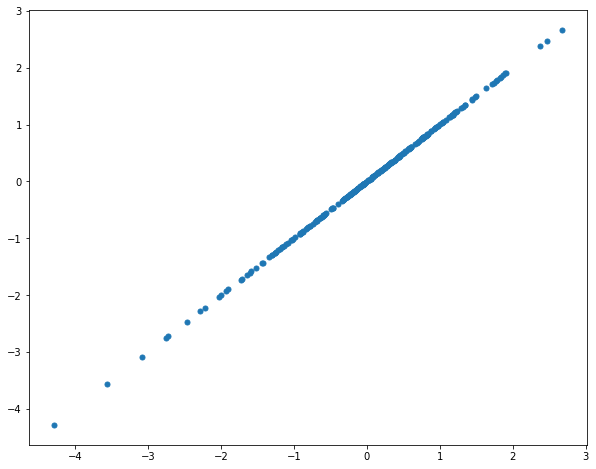

In [45]:
weights = np.linalg.lstsq(snpdata_i.val, phenodata_i.val)[0] #usually would add a 1's column
predicted = snpdata_i.val.dot(weights)

import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.plot(phenodata_i.val, predicted, '.', markersize=10)
plt.show() #Easy to 'predict' seen 250 cases with 5000 variables.

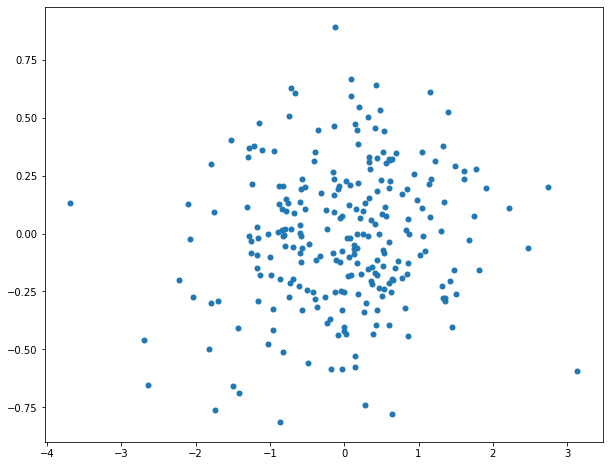

In [46]:
# How does it predict unseen cases?
phenoreader_unseen = Pheno(pheno_fn)[-2::-2,:]
snpreader_u,phenoreader_u  = pstutil.intersect_apply([snpreader,phenoreader_unseen])

snpdata_u = snpreader_u.read()
phenodata_u = phenoreader_u.read()

predicted_u = snpdata_u.val.dot(weights)

plt.plot(phenodata_u.val, predicted_u, '.', markersize=10)
plt.show() #Hard to predict unseen 250 cases with 5000 variables.

*<font color='red'>see PowerPoint summary</font>*

# Standardization, Kernels

###  To Unit standardize: read data, ".standardize()"

In [47]:
snpreader = Bed(all_bed_file,count_A1=False)
snpdata = snpreader.read()
snpdata = snpdata.standardize() #In place AND returns self
print(snpdata.val[:,:5])

[[ 0.30156099  0.2481353  -0.50673344 -1.68318496  0.84178108]
 [ 0.30156099  0.2481353  -0.50673344 -0.29670641  0.84178108]
 [ 0.30156099  0.2481353  -0.50673344 -1.68318496 -0.77702869]
 ...
 [ 0.30156099  0.2481353   1.01043255  1.08977214  0.84178108]
 [ 0.30156099  0.2481353   1.01043255 -0.29670641  0.84178108]
 [ 0.30156099  0.2481353   1.01043255  1.08977214 -0.77702869]]


### Sets means per sid to 0 and stdev to 1 and fills nan with 0.
In one line:

In [48]:
snpdata = Bed(all_bed_file,count_A1=False).read().standardize()
print(snpdata.val[:,:5])

[[ 0.30156099  0.2481353  -0.50673344 -1.68318496  0.84178108]
 [ 0.30156099  0.2481353  -0.50673344 -0.29670641  0.84178108]
 [ 0.30156099  0.2481353  -0.50673344 -1.68318496 -0.77702869]
 ...
 [ 0.30156099  0.2481353   1.01043255  1.08977214  0.84178108]
 [ 0.30156099  0.2481353   1.01043255 -0.29670641  0.84178108]
 [ 0.30156099  0.2481353   1.01043255  1.08977214 -0.77702869]]


### Beta standardization

In [49]:
from pysnptools.standardizer import Beta
snpdataB = Bed(all_bed_file,count_A1=False).read().standardize(Beta(1,25))
print(snpdataB.val[:,:4])

[[ 7.40112054e-01  7.15532756e-01 -5.02003205e-04 -1.89970988e-04]
 [ 7.40112054e-01  7.15532756e-01 -5.02003205e-04 -3.34874723e-05]
 [ 7.40112054e-01  7.15532756e-01 -5.02003205e-04 -1.89970988e-04]
 ...
 [ 7.40112054e-01  7.15532756e-01  1.00100040e-03  1.22996043e-04]
 [ 7.40112054e-01  7.15532756e-01  1.00100040e-03 -3.34874723e-05]
 [ 7.40112054e-01  7.15532756e-01  1.00100040e-03  1.22996043e-04]]


### To create an kernel (the relateness of each iid pair as the dot product of their standardized SNP values)

In [50]:
from pysnptools.standardizer import Unit
kerneldata = Bed(all_bed_file,count_A1=False).read_kernel(standardizer=Unit())
print(kerneldata.val[:,:4])

[[5081.6121922   253.32922313  165.9842232   360.75883739]
 [ 253.32922313 5061.87849635  384.04149913  466.05844787]
 [ 165.9842232   384.04149913 4922.10583668  171.75732175]
 ...
 [-130.76998392 -334.33599388 -257.64796899 -255.81034978]
 [-298.66392286 -127.02308706 -305.3966     -141.91272418]
 [-287.66887036 -291.41483161 -289.73600005 -364.74382324]]


In [51]:
kerneldata = Bed(all_bed_file,count_A1=False).read_kernel(standardizer=Unit(),block_size=500)
print(kerneldata.val[:,:4])

[[5081.6121922   253.32922313  165.9842232   360.75883739]
 [ 253.32922313 5061.87849635  384.04149913  466.05844787]
 [ 165.9842232   384.04149913 4922.10583668  171.75732175]
 ...
 [-130.76998392 -334.33599388 -257.64796899 -255.81034978]
 [-298.66392286 -127.02308706 -305.3966     -141.91272418]
 [-287.66887036 -291.41483161 -289.73600005 -364.74382324]]


*<font color='red'>see PowerPoint summary</font>*

## PstReader
### Every SnpReader is a PstReader

In [52]:
from pysnptools.snpreader import Bed
pstreader = Bed(all_bed_file,count_A1=False)
print(pstreader.row_count, pstreader.col_count)

500 5000


In [53]:
print(pstreader.col_property)

[[1.000e+00       nan       nan]
 [1.000e+00 1.000e+00 1.000e+00]
 [1.000e+00 2.000e+00 2.000e+00]
 ...
 [5.000e+00 4.997e+03 4.997e+03]
 [5.000e+00 4.998e+03 4.998e+03]
 [5.000e+00 4.999e+03 4.999e+03]]


### Can also create PstData from scratch, on the fly

In [54]:
from pysnptools.pstreader import PstData
data1 = PstData(row=['a','b','c'],
                col=['y','z'],
                val=[[1,2],[3,4],[np.nan,6]],
                row_property=['A','B','C'])
reader2 = data1[data1.row < 'c', data1.col_to_index(['z','y'])]
print(reader2)

PstData()[[0,1],[1,0]]


In [55]:
print(reader2.read().val)

[[2. 1.]
 [4. 3.]]


In [56]:
print(reader2.row_property)

['A' 'B']


In [57]:
print(reader2.col_property.shape, reader2.col_property.dtype)

(2, 0) <U1


### Two new PstReaders: PstNpz and PstHdf5

In [58]:
from pysnptools.pstreader import PstNpz, PstHdf5
fnnpz = "delme.pst.npz"
PstNpz.write(fnnpz,data1)
data2 = PstNpz(fnnpz).read()

fnhdf5 = "delme.pst.hdf5"
PstHdf5.write(fnhdf5,data2)
data3 = PstHdf5(fnhdf5).read()

print(data2, data3)

PstData(PstNpz('delme.pst.npz')) PstData(PstHdf5('delme.pst.hdf5'))


In [59]:
print(data2.val)
print(data3.val)

[[ 1.  2.]
 [ 3.  4.]
 [nan  6.]]
[[ 1.  2.]
 [ 3.  4.]
 [nan  6.]]


*<font color='red'>see PowerPoint summary</font>*

## IntRangeSet
### Union of two sets
<img src="example1.png">

In [60]:
from pysnptools.util import IntRangeSet
a = IntRangeSet("100:500,501:1000") # a is the set of integers from 100 to 500 (exclusive) and 501 to 1000 (exclusive)
b = IntRangeSet("-20,400:600")      # b is the set of integers -20 and the range 400 to 600 (exclusive)
c = a | b                           # c is the union of a and b, namely -20 and 100 to 1000 (exclusive)
print(c)
print(200 in c)
print(-19 in c)

IntRangeSet('-20,100:1000')
True
False


### Set difference
Suppose we want to find the intron regions of a gene but we are given only the transcription region and the exon regions.
<img src="example2.png">

In [61]:
from pysnptools.util import IntRangeSet
line = "chr15   29370   37380   29370,32358,36715   30817,32561,37380"
chr,trans_start,trans_last,exon_starts,exon_lasts = line.split() # split the line on white space
trans_start = int(trans_start)
trans_stop = int(trans_last) + 1 # add one to convert the inclusive "last" value into a Pythonesque exclusive "stop" value
int_range_set = IntRangeSet((trans_start,trans_stop)) # creates a IntRangeSet from 29370 (inclusive) to 37381 (exclusive)
print(int_range_set) # print at any time to see the current value

IntRangeSet('29370:37381')


Parse the exon start and last lists from strings to lists of integers (converting ‘last’ to ‘stop’)

In [62]:
exon_starts = [int(start) for start in exon_starts.strip(",").split(',')]
exon_stops = [int(last)+1 for last in exon_lasts.strip(",").split(',')]
assert len(exon_starts) == len(exon_stops)

Zip together the two lists to create an iterable of exon_start,exon_stop tuples. Then ‘set subtract’ all these ranges from int_range_set.

In [63]:
int_range_set -= zip(exon_starts,exon_stops)
print(int_range_set) # See what it looks like

IntRangeSet('30818:32358,32562:36715')


Create the desired output by iterating through each contiguous range of integers.

In [64]:
for start, stop in int_range_set.ranges():
    print("{0}   {1}     {2}".format(chr, start, stop-1))

chr15   30818     32357
chr15   32562     36714


*<font color='red'>see PowerPoint summary</font>*

## FastLMM

In [65]:
# import the algorithm
from fastlmm.association import single_snp_leave_out_one_chrom
from pysnptools.snpreader import Bed

# set up data
##############################
all_bed_file = example_file("doc/ipynb/all.*",endswith="*.bed")
snps = Bed(all_bed_file,count_A1=False)
pheno_fn = example_file("doc/ipynb/pheno_10_causals.txt")
cov_fn = example_file("doc/ipynb/cov.txt")

# run gwas
###################################################################
results_df = single_snp_leave_out_one_chrom(snps,  pheno_fn, covar=cov_fn)

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,2.990684e-23,0.418653,0.040052,0.424521,0.0,0.451117
1,392,snp1422_m0_.49m1_.5,3.0,2392.0,2392.0,8.251922e-23,-0.416495,0.040300,0.420587,0.0,0.279710
2,650,snp1200_m0_.37m1_.36,3.0,2650.0,2650.0,3.048007e-14,0.328870,0.042021,0.331240,0.0,0.279710
3,3,snp433_m0_.14m1_.11,3.0,2003.0,2003.0,9.202499e-10,-0.268289,0.042973,0.269670,0.0,0.279710
4,274,snp2832_m0_.46m1_.1,4.0,3274.0,3274.0,7.069762e-04,0.170421,0.050003,0.151124,0.0,0.542046
5,13,snp1413_m0_.04m1_.03,3.0,2013.0,2013.0,8.161238e-04,-0.148719,0.044157,0.149377,0.0,0.279710
6,214,snp2804_m0_.16m1_.3,3.0,2214.0,2214.0,1.239806e-03,0.150705,0.046396,0.144180,0.0,0.279710
7,117,snp751_m0_.04m1_.25,1.0,117.0,117.0,1.527432e-03,-0.152430,0.047827,0.141523,0.0,0.614963
8,265,snp1440_m0_.35m1_.32,4.0,3265.0,3265.0,1.771049e-03,0.136281,0.043358,0.139610,0.0,0.542046
9,307,snp2162_m0_.61m1_.42,2.0,1307.0,1307.0,1.816576e-03,-0.143296,0.045700,0.139280,0.0,0.534262


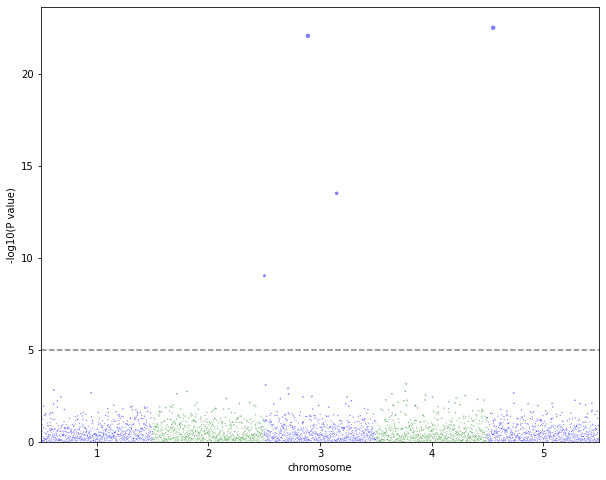

In [66]:
# manhattan plot
import pylab
import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df[["Chr", "ChrPos", "PValue"]],pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

*<font color='red'>see PowerPoint summary</font>*